In [1]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import colors
from matplotlib.colors import LogNorm
import matplotlib as mpl 
mpl.rcParams["image.origin"] = 'lower'
# mpl.rcParams["image.dpi"] = 200
import os
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import mplhep as hep
plt.style.use(hep.style.CMS)
#from plotting_utils import *
import uproot
import awkward as ak
import dask.dataframe as dd
from dask.distributed import Client

client = Client(dashboard=True)

/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/distributed/deploy/local.py:161: UserWarning: Setting `dashboard` is discouraged. Please set `dashboard_address` to affect the scheduler (more common) and `worker_dashboard_address` for the worker (less common).
  warnings.warn(


In [2]:
input_folder = "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/reco_comparison/overlapping_objects_studies/electrons_genmatching"

output_folder = "plots/electrons_gen_matching_v2"
os.makedirs(output_folder, exist_ok=True)
df = pd.HDFStore(f"{input_folder}/Mustache_126X_mcRun3_2023_v1.hdf5", "r")["df"]
df.rename(columns={"output_object.csv":"genpart_index"}, inplace=True)
df = df.iloc[:-1]

#df = dd.from_pandas(df, npartitions=4)

In [59]:
print(df.head(50))

    genpart_index  elematched  phomatched  ele_index  pho_index  \
0             0.0         1.0         1.0        6.0        6.0   
1             1.0         1.0         1.0        3.0        3.0   
2             2.0         1.0         1.0        5.0        5.0   
3             3.0         1.0         1.0        0.0        0.0   
4             4.0         1.0         1.0        7.0        4.0   
5             5.0         1.0         1.0        4.0        4.0   
6             6.0         1.0         1.0        1.0        1.0   
7             7.0         1.0         1.0        2.0        2.0   
8             0.0         1.0         1.0        4.0        4.0   
9             1.0         1.0         1.0        4.0        4.0   
10            2.0         1.0         1.0        1.0        0.0   
11            3.0         1.0         1.0        2.0        2.0   
12            4.0         1.0         1.0        5.0        5.0   
13            5.0         1.0         1.0        3.0        3.

In [4]:
list(df.columns)

['genpart_index',
 'elematched',
 'phomatched',
 'ele_index',
 'pho_index',
 'deltaR_genPart_ele',
 'deltaR_genPart_pho',
 'calomatched',
 'caloindex',
 'sc_matched',
 'sc_index',
 'seed_index',
 'en_seed',
 'et_seed',
 'en_seed_calib',
 'et_seed_calib',
 'seed_eta',
 'seed_phi',
 'seed_iz',
 'sc_eta',
 'sc_phi',
 'sc_swissCross',
 'sc_r9',
 'sc_sigmaIetaIeta',
 'sc_sigmaIetaIphi',
 'sc_sigmaIphiIphi',
 'sc_e5x5',
 'sc_swissCross_f5x5',
 'sc_r9_f5x5',
 'sc_sigmaIetaIeta_f5x5',
 'sc_sigmaIetaIphi_f5x5',
 'sc_sigmaIphiIphi_f5x5',
 'sc_e5x5_f5x5',
 'ele_eta',
 'ele_phi',
 'ele_energy',
 'ele_et',
 'ele_ecalEnergy',
 'ele_ecalSCEnergy',
 'ele_scRawEnergy',
 'ele_scRawESEnergy',
 'ele_SCfbrem',
 'ele_tracfbrem',
 'ele_e5x5',
 'ele_e3x3',
 'ele_sigmaIEtaIEta',
 'ele_sigmaIEtaIPhi',
 'ele_sigmaIPhiIPhi',
 'ele_ecalIso03',
 'ele_trkIso03',
 'ele_hcalIso03',
 'ele_pfChargedHadronIso',
 'ele_pfNeutralHadronIso',
 'ele_pfPhotonIso',
 'ele_HoE',
 'ele_deltaEtaSeedClusterAtCalo',
 'ele_deltaPhiSeed

In [3]:
def calculate_mean_std(column):
    mean = column.mean()
    std = column.std()
    return pd.Series({'mean': mean, 'std': std})
grouped_stats = df.groupby(['runId', 'eventId'])['genpart_et'].apply(calculate_mean_std)
print(grouped_stats)

runId    eventId      
1.0      1.0      mean    268.451014
                  std     135.683647
         2.0      mean    312.736193
                  std     116.624841
         3.0      mean    116.826430
                             ...    
10000.0  48.0     std     139.090889
         49.0     mean    287.384393
                  std     162.700055
         50.0     mean    179.264867
                  std     133.208210
Name: genpart_et, Length: 1000000, dtype: float64


In [96]:
def calculate_deltaR(group):
    # Extract relevant columns
    group = group.sort_values(by='caloindex')
    print(group['caloindex'])
    eta = group['calo_geneta'].values
    phi = group['calo_genphi'].values
    calo_et_gen = group['calo_et_gen'].values
    ele_et=group['ele_et'].values
    ele_index = group['ele_index'].values
    elematched = group['elematched'].values
    
    # Calculate differences and means
    eta_diff = eta[::2] - eta[1::2]
    dphi = (phi[::2] - phi[1::2])
    dphi[dphi > np.pi] -= 2 * np.pi
    dphi[dphi < -np.pi] += 2 * np.pi
    dr_diff = np.sqrt(eta_diff**2 + dphi**2)
    eta_mean = (eta[::2] + eta[1::2]) / 2
    phi_mean = (phi[::2] + phi[1::2]) / 2
    
    data = {
        'deltaR': dr_diff,
        'eta_mean': eta_mean,
        'phi_mean': phi_mean,
        "calo_energy1": calo_et_gen[::2],
        'calo_energy2': calo_et_gen[1::2],
        'ele_et1':ele_et[::2],
        'ele_et2':ele_et[1::2],
        'ele_index1': ele_index[::2],
        'ele_index2': ele_index[1::2],
        'ele_matched1': elematched[::2],
        'ele_matched2': elematched[1::2],
    }
    
    return pd.DataFrame(data)

grouped_deltas = df.groupby(['runId', 'eventId']).apply(calculate_deltaR)
grouped_deltas.to_csv('grouped_deltas.csv', index=False)

In [14]:
valid_energy_mask = (grouped_deltas['calo_energy1'] != -999.0) & (grouped_deltas['calo_energy2'] != -999)
grouped_deltas = grouped_deltas[valid_energy_mask]

In [36]:
valid_energy_mask = (grouped_deltas['calo_energy1'] != -1.0) & (grouped_deltas['calo_energy2'] != -1)
grouped_deltas = grouped_deltas[valid_energy_mask]

# Event same ele_index

In [71]:
grouped_deltas = pd.read_csv('grouped_deltas.csv')
#valid_energy_mask = (grouped_deltas['calo_energy1'] != -999.0) & (grouped_deltas['calo_energy2'] != -999)
#grouped_deltas = grouped_deltas[valid_energy_mask]
valid_energy_mask = (grouped_deltas['calo_energy1'] != -1.0) & (grouped_deltas['calo_energy2'] != -1)
grouped_deltas = grouped_deltas[valid_energy_mask]

In [72]:
same_ele_index_mask = grouped_deltas['ele_index1'] == grouped_deltas['ele_index2']
same_ele_events = grouped_deltas[same_ele_index_mask]
print(same_ele_events)

           deltaR  eta_mean  phi_mean  calo_energy1  calo_energy2     ele_et1  \
8        0.000000  2.361738 -2.881292    167.584058    167.584058  281.004059   
11       0.396164 -2.731669  1.005955     75.991463     74.392717   74.828079   
15       3.377951 -1.846642 -0.777667     89.566869    134.734369   88.921127   
20       0.610287  1.786398 -0.100647    276.654732    167.178094  173.634186   
23       0.057895 -1.866780 -0.287161    164.659487    488.966574  506.989685   
...           ...       ...       ...           ...           ...         ...   
1999975  0.050395 -1.935078  0.769050    380.197949    127.127550  401.761902   
1999983  0.000000 -2.975633  0.038670    287.460506    287.460506   57.519592   
1999986  0.259072 -0.342276 -1.717838     67.029474     50.851507   67.504875   
1999991  0.535124 -2.783971  1.412874     42.936397    326.650902  489.576569   
1999995  0.258128 -2.157016  2.394996    358.305929    495.885051  356.996521   

            ele_et2  ele_in

In [73]:
max_energy1 = (same_ele_events['calo_energy2']).max()
min_energy1 = same_ele_events['calo_energy2'].min()

# Print the maximum and minimum values
print("Maximum energy1:", max_energy1)
print("Minimum energy1:", min_energy1)

Maximum energy1: 499.9992716211869
Minimum energy1: 1.1086178601062429


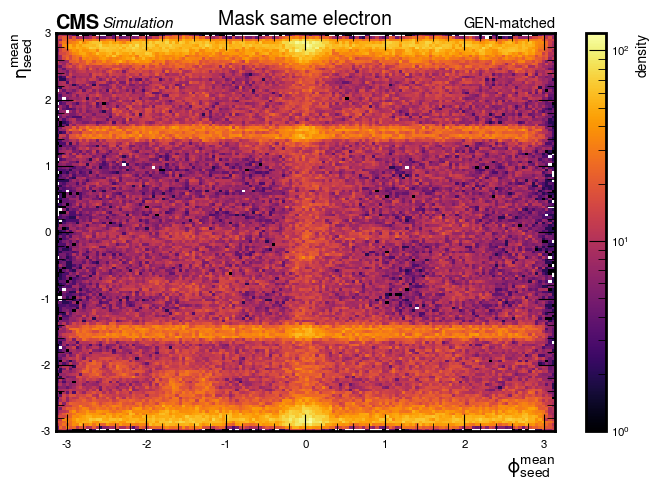

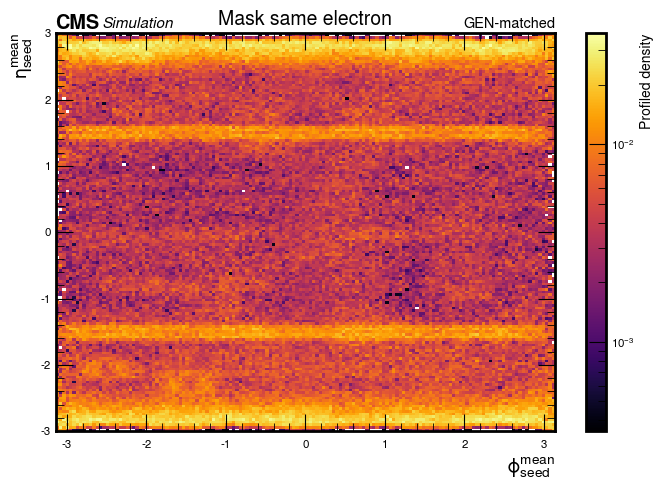

In [74]:
fig, ax = plt.subplots(1,1,dpi=100, figsize=(7, 5))

A,xedges,yedges  = np.histogram2d(same_ele_events.phi_mean ,same_ele_events.eta_mean,bins=(150, 150), range=((-np.pi,np.pi),(-3,3)))

s = 1#np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")

fig.colorbar(I, ax=ax, label="density")
ax.set_ylabel("$\eta^{mean}_{seed}$", fontsize=14)
ax.set_xlabel("$\phi^{mean}_{seed}$", fontsize=14)
plt.title('Mask same electron',fontsize=14)
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax,fontsize=11)
plt.tight_layout()
plt.savefig('plots/eta_phi.png')
plt.show()
fig, ax = plt.subplots(1,1,dpi=100, figsize=(7, 5))

A,xedges,yedges  = np.histogram2d(same_ele_events.phi_mean ,same_ele_events.eta_mean,bins=(150, 150), range=((-np.pi,np.pi),(-3,3)))

s = np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")

fig.colorbar(I, ax=ax, label="Profiled density")
ax.set_ylabel("$\eta^{mean}_{seed}$", fontsize=14)
ax.set_xlabel("$\phi^{mean}_{seed}$", fontsize=14)
plt.title('Mask same electron',fontsize=14)
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax,fontsize=11)
plt.tight_layout()
plt.savefig('plots/eta_phi_prof.png')


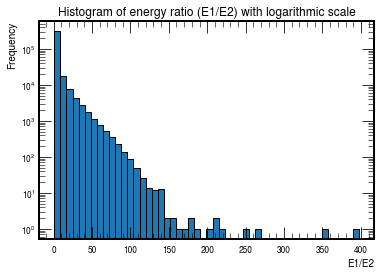

min energyratio:  1.0


In [75]:

energy_ratio = same_ele_events['calo_energy1'] / same_ele_events['calo_energy2']
energy_ratio[same_ele_events['calo_energy1'] < same_ele_events['calo_energy2']] = same_ele_events['calo_energy2'] / same_ele_events['calo_energy1']

plt.hist(energy_ratio, bins=50, edgecolor='black', log=True)  # Set log=True
plt.xlabel('E1/E2')
plt.ylabel('Frequency')
plt.title('Histogram of energy ratio (E1/E2) with logarithmic scale')
plt.savefig('plots/hist_e1-e2.png')
plt.show()
print('min energyratio: ', energy_ratio.min())

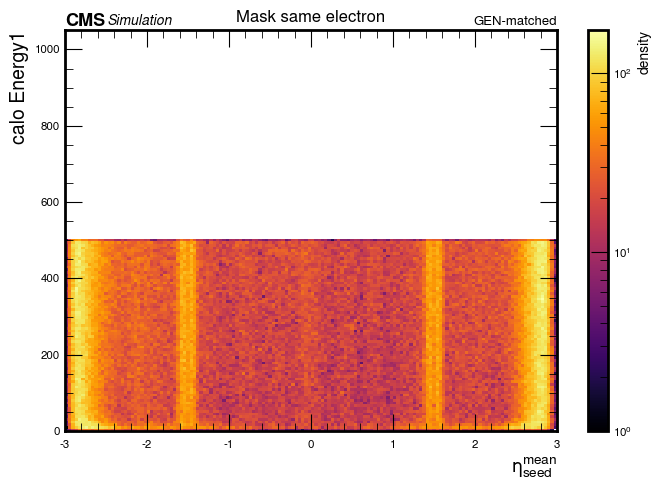

In [76]:
fig, ax = plt.subplots(1,1,dpi=100, figsize=(7, 5))

A,xedges,yedges  = np.histogram2d(same_ele_events.eta_mean ,same_ele_events.calo_energy1,bins=(150, 150), range=((-3,3),(0,1050)))

s = 1 #np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")

fig.colorbar(I, ax=ax, label="density")
ax.set_xlabel("$\eta^{mean}_{seed}$", fontsize=14)
ax.set_ylabel("calo Energy1", fontsize=14)
plt.title('Mask same electron')
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
plt.savefig('plots/e1_eta.png')

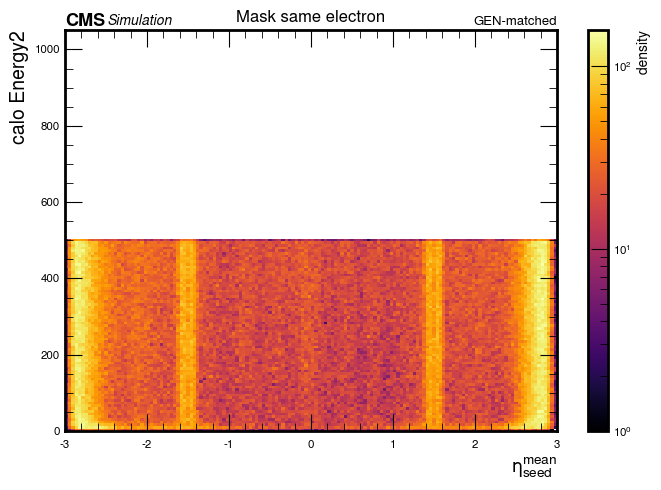

In [77]:
fig, ax = plt.subplots(1,1,dpi=100, figsize=(7, 5))

A,xedges,yedges  = np.histogram2d(same_ele_events.eta_mean ,same_ele_events.calo_energy2,bins=(150, 150), range=((-3,3),(0,1050)))

s = 1#np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")

fig.colorbar(I, ax=ax, label=" density")
ax.set_xlabel("$\eta^{mean}_{seed}$", fontsize=14)
ax.set_ylabel("calo Energy2", fontsize=14)
plt.title('Mask same electron')
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
plt.savefig('plots/e2_eta.png')

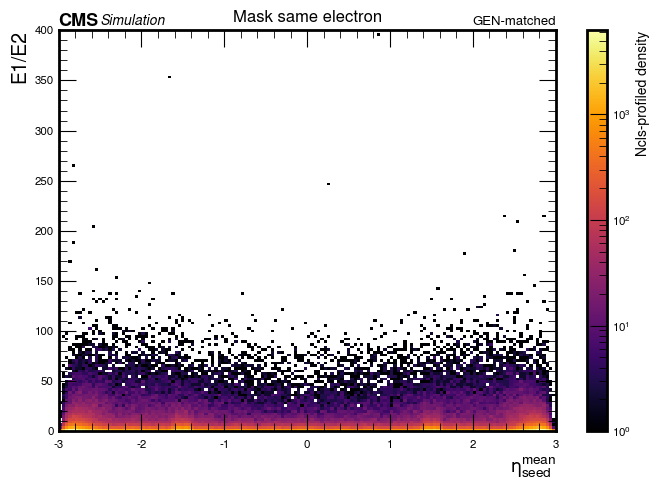

In [78]:
fig, ax = plt.subplots(1,1,dpi=100, figsize=(7, 5))

A,xedges,yedges  = np.histogram2d(same_ele_events.eta_mean ,energy_ratio,bins=(150, 150), range=((-3,3),(0,400)))

s = 1#np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")

fig.colorbar(I, ax=ax, label="Ncls-profiled density")
ax.set_xlabel("$\eta^{mean}_{seed}$", fontsize=14)
ax.set_ylabel("E1/E2", fontsize=14)
plt.title('Mask same electron')
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
plt.savefig('plots/e1-e2_eta.png')

## ele_et

In [87]:
max_energy1 = (same_ele_events['ele_et1']).max()
min_energy1 = same_ele_events['ele_et2'].min()

# Print the maximum and minimum values
print("Maximum energy1:", max_energy1)
print("Minimum energy1:", min_energy1)

Maximum energy1: 3098.338623046875
Minimum energy1: 0.0643110051751136


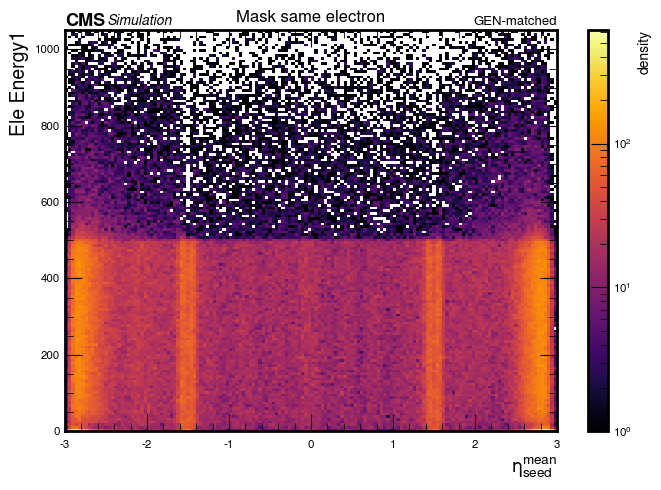

In [88]:
fig, ax = plt.subplots(1,1,dpi=100, figsize=(7, 5))

A,xedges,yedges  = np.histogram2d(same_ele_events.eta_mean ,same_ele_events.ele_et1,bins=(150, 150), range=((-3,3),(0,1050)))

s = 1#np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")

fig.colorbar(I, ax=ax, label="density")
ax.set_xlabel("$\eta^{mean}_{seed}$", fontsize=14)
ax.set_ylabel("Ele Energy1", fontsize=14)
plt.title('Mask same electron')
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
plt.savefig('plots/eleet1_eta.png')

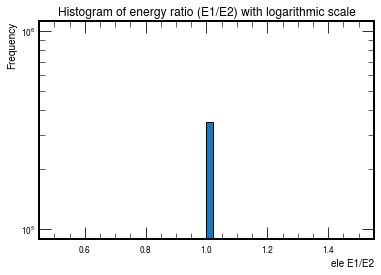

min energyratio:  1.0


'\nfig, ax = plt.subplots(1,1,dpi=100, figsize=(7, 5))\n\nA,xedges,yedges  = np.histogram2d(same_ele_events.eta_mean ,energy_ratio,bins=(150, 150), range=((-3,3),(0,400)))\n\ns = 1#np.expand_dims(np.sum(A, axis=-1), axis=1)\na = A/s\nX, Y = np.meshgrid(xedges, yedges)\nI = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")\n\nfig.colorbar(I, ax=ax, label="density")\nax.set_xlabel("$\\eta^{mean}_{seed}$", fontsize=14)\nax.set_ylabel("ele E1/E2", fontsize=14)\nplt.title(\'Mask same electron\')\nhep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)\nplt.tight_layout()\nplt.savefig(\'plots/ele_e1-e2_eta.png\')\n'

In [92]:
energy_ratio = same_ele_events['ele_et1'] / same_ele_events['ele_et2']
energy_ratio[same_ele_events['ele_et1'] < same_ele_events['ele_et2']] = same_ele_events['ele_et2'] / same_ele_events['ele_et1']

plt.hist(energy_ratio, bins=50, edgecolor='black', log=True)  # Set log=True
plt.xlabel('ele E1/E2')
plt.ylabel('Frequency')
plt.title('Histogram of energy ratio (E1/E2) with logarithmic scale')
plt.savefig('plots/hist_e1-e2.png')
plt.show()
print('min energyratio: ', energy_ratio.min())
'''
fig, ax = plt.subplots(1,1,dpi=100, figsize=(7, 5))

A,xedges,yedges  = np.histogram2d(same_ele_events.eta_mean ,energy_ratio,bins=(150, 150), range=((-3,3),(0,400)))

s = 1#np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")

fig.colorbar(I, ax=ax, label="density")
ax.set_xlabel("$\eta^{mean}_{seed}$", fontsize=14)
ax.set_ylabel("ele E1/E2", fontsize=14)
plt.title('Mask same electron')
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
plt.savefig('plots/ele_e1-e2_eta.png')
'''

## Delta R study

In [79]:
total_events = len(grouped_deltas)

same_ele_index_events = grouped_deltas[grouped_deltas['ele_index1'] == grouped_deltas['ele_index2']]
same_ele_index_count = len(same_ele_index_events)
percentage_same_ele_index = (same_ele_index_count / total_events) * 100

print(f"Percentage of events with the same ele_index: {percentage_same_ele_index:.2f}%")

Percentage of events with the same ele_index: 18.30%


In [80]:
eta_mean_range = (1.4, 1.6)

filtered_events = grouped_deltas[(grouped_deltas['eta_mean'] >= eta_mean_range[0]) & 
                                 (grouped_deltas['eta_mean'] <= eta_mean_range[1]) &
                                 (grouped_deltas['ele_index1'] == grouped_deltas['ele_index2'])]
total_events_eta_range = len(grouped_deltas[(grouped_deltas['eta_mean'] >= eta_mean_range[0]) & 
                                             (grouped_deltas['eta_mean'] <= eta_mean_range[1])])
same_ele_eta_range_count = len(filtered_events)
percentage_same_ele_index_eta_range = (same_ele_eta_range_count / total_events_eta_range) * 100

print(f"Percentage of events with the same ele_index in the range eta {eta_mean_range}: {percentage_same_ele_index_eta_range:.2f}%")

Percentage of events with the same ele_index in the range eta (1.4, 1.6): 29.93%


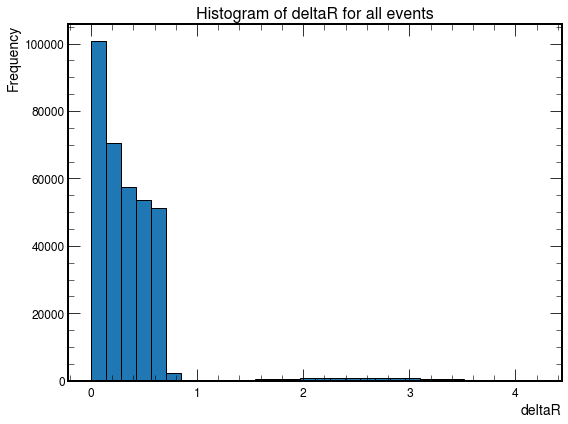

In [81]:
plt.figure(figsize=(8, 6))  
plt.hist(same_ele_events['deltaR'], bins=30, edgecolor='black')
plt.xlabel('deltaR', fontsize=14)  
plt.ylabel('Frequency', fontsize=14)  
plt.title('Histogram of deltaR for all events', fontsize=16)  
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12) 
plt.tight_layout() 
plt.savefig('plots/deltaR_histogram.png')
plt.show()

In [82]:
print('delta r max: ',same_ele_events['deltaR'].max())

delta r max:  4.22333456717407


interval=[ 0.0 0.42233345671740696 ]
n1:  154358
ntot:  928839
interval=[ 0.42233345671740696 0.8446669134348139 ]
n1:  107320
ntot:  720218
interval=[ 0.8446669134348139 1.2670003701522208 ]
n1:  215
ntot:  9799
interval=[ 1.2670003701522208 1.6893338268696279 ]
n1:  945
ntot:  19215
interval=[ 1.6893338268696279 2.111667283587035 ]
n1:  1742
ntot:  27756
interval=[ 2.111667283587035 2.5340007403044416 ]
n1:  2420
ntot:  32382
interval=[ 2.5340007403044416 2.9563341970218486 ]
n1:  2725
ntot:  32898
interval=[ 2.9563341970218486 3.3786676537392557 ]
n1:  1825
ntot:  27076
interval=[ 3.3786676537392557 3.801001110456663 ]
n1:  800
ntot:  13512
interval=[ 3.801001110456663 4.22333456717407 ]
n1:  163
ntot:  3686


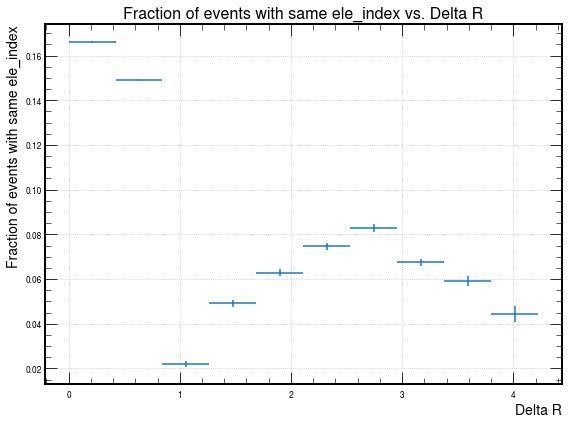

In [84]:
def fraction_same_ele_index_vs_deltaR(num_intervals):
    deltaR_max = same_ele_events['deltaR'].max()
    deltaR_values, y = np.linspace(0, deltaR_max, num_intervals + 1, retstep=True)

    fraction_list = []
    yer = []

    for i in range(len(deltaR_values) - 1):
        lower_bound = deltaR_values[i]
        upper_bound = deltaR_values[i + 1]
        print('interval=[',lower_bound,upper_bound,']')
        mask = (same_ele_events['deltaR'] > lower_bound) & (same_ele_events['deltaR'] <= upper_bound)
        mask2 = (grouped_deltas['deltaR'] > lower_bound) & (grouped_deltas['deltaR'] <= upper_bound)

        n1 = len(same_ele_events[mask])
        print('n1: ',n1)
        ntot = len(grouped_deltas[mask2])
        print('ntot: ',ntot)
        if ntot == 0:
            ntot = 1
        fraction = n1 / ntot
        fraction_list.append(fraction)
        yer.append(np.sqrt(n1 + n1**2 / ntot) / ntot)

    plt.figure(figsize=(8,6))  # Larger figsize
    plt.errorbar(deltaR_values[:-1] + y / 2, fraction_list, xerr=np.ones(num_intervals) * y / 2, yerr=yer, fmt='none')
    #plt.scatter(deltaR_values[:-1] + y / 2, fraction_list)
    plt.xlabel('Delta R', fontsize=14)
    plt.ylabel('Fraction of events with same ele_index', fontsize=14) 
    plt.title('Fraction of events with same ele_index vs. Delta R', fontsize=16)  
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('plots/fraction_deltaR.png')
    plt.show()

num_intervals = 10
fraction_same_ele_index_vs_deltaR(num_intervals)


Text(0.5, 1.0, 'Eta')

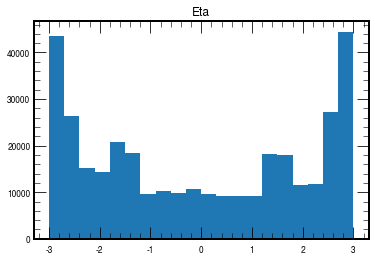

In [85]:
plt.hist(same_ele_events.eta_mean, bins=20, range=(-3,3))
plt.title('Eta')

Text(0.5, 1.0, 'phi')

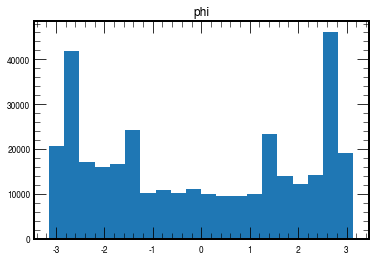

In [86]:
plt.hist(same_ele_events.eta_mean, bins=20, range=(-np.pi,np.pi))
plt.title('phi')